cargue de librerias y datos

In [1]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.decomposition import PCA
import numpy as np

In [2]:
data = pd.read_csv("C:/Users/ASUS/Downloads/export_dataframe_twiter.csv")
data.head()

tweet                 date  \
0  @KendraWrites Not even going toward the murder...  2020-11-14 18:27:25   
1  @mxrlxn361 @kokofnbr Aso ups also the i Land, ...  2020-11-13 23:55:22   
2  14 November 1969. 16.22.00 UTC/GMT. Launch of ...  2020-11-13 23:34:00   
3  Loved walking by a part of the Land of Make Be...  2020-11-13 21:59:52   
4  @CryptoRudolphus @100trillionUSD @spunzamboni ...  2020-11-13 15:28:44   

                    id                                               link  \
0  1327679544510263296  https://twitter.com/i/web/status/1327679544510...   
1  1327399690044891140  https://twitter.com/i/web/status/1327399690044...   
2  1327394310820655105  https://twitter.com/i/web/status/1327394310820...   
3  1327370622733791232  https://twitter.com/i/web/status/1327370622733...   
4  1327272190786621447  https://twitter.com/i/web/status/1327272190786...   

                    Pelicula  
0  From the Land of the Moon  
1  From the Land of the Moon  
2  From the Land of the Moon  
3  From the Land of the Moon  
4  From the Land of the Moon

limpieza de datos

In [3]:
import re
 
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'
 
def text_clean(row):
    text = row['tweet']

    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")

    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")

    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")

    return text, links, hashtags, mentions

In [4]:
data[['clean', 'links', 'hashtags', 'mentions']] = data.apply(text_clean, axis=1, result_type='expand')

In [5]:
data.head()

tweet                 date  \
0  @KendraWrites Not even going toward the murder...  2020-11-14 18:27:25   
1  @mxrlxn361 @kokofnbr Aso ups also the i Land, ...  2020-11-13 23:55:22   
2  14 November 1969. 16.22.00 UTC/GMT. Launch of ...  2020-11-13 23:34:00   
3  Loved walking by a part of the Land of Make Be...  2020-11-13 21:59:52   
4  @CryptoRudolphus @100trillionUSD @spunzamboni ...  2020-11-13 15:28:44   

                    id                                               link  \
0  1327679544510263296  https://twitter.com/i/web/status/1327679544510...   
1  1327399690044891140  https://twitter.com/i/web/status/1327399690044...   
2  1327394310820655105  https://twitter.com/i/web/status/1327394310820...   
3  1327370622733791232  https://twitter.com/i/web/status/1327370622733...   
4  1327272190786621447  https://twitter.com/i/web/status/1327272190786...   

                    Pelicula  \
0  From the Land of the Moon   
1  From the Land of the Moon   
2  From the Land of the Moon   
3  From the Land of the Moon   
4  From the Land of the Moon   

                                               clean  \
0   Not even going toward the murders in Oklahoma...   
1    Aso ups also the i Land, Dark, Pose, a Fall ...   
2  14 November 1969. 16.22.00 UTC/GMT. Launch of ...   
3  Loved walking by a part of the Land of Make Be...   
4      I don’t see how that holds true. The probl...   

                       links                              hashtags  \
0                         []                                    []   
1                         []                                    []   
2  [https://t.co/XX4i5xbChZ]                                    []   
3  [https://t.co/h4X71OoYip]  [#HappyWorldKindnessDay, #WearAMask]   
4                         []                                    []   

                                            mentions  
0                                    [@KendraWrites]  
1                            [@mxrlxn361, @kokofnbr]  
2                                                 []  
3                                                 []  
4  [@CryptoRudolphus, @100trillionUSD, @spunzambo...

# Analisis de emojis 

In [6]:
import regex
import emoji
 
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list
 
data['emojis'] = data['clean'].apply(lambda text: get_emojis(text))

In [7]:
from collections import Counter
 
temp_emojis = pd.DataFrame(list(zip(Counter(sum(data.emojis.values,[])).keys(),Counter(sum(data.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cnt']
temp_emojis.sort_values('cnt', ascending=False, inplace=True)
temp_emojis.head()

emoji  cnt
11     😂  593
52     😭  398
50     🤣  258
19    ❤️  192
32     🥺  160

In [8]:
prueba_inic=data.groupby(['Pelicula'], as_index = False)[['tweet']].count()
temp_emoji = []
for day in prueba_inic['Pelicula']:
    temp = pd.DataFrame(Counter(sum(data[data['Pelicula']==day]['emojis'].values,[])).most_common(10))
    temp['Pelicula'] = day
    temp_emoji.append(temp)

temp_emoji = pd.concat(temp_emoji)
temp_emoji.columns = ['emojis', 'tweet_count', 'Pelicula']
 
temp_emoji = temp_emoji.pivot(index='emojis', columns='Pelicula').reset_index()
temp_emoji.columns = ['emojis'] + list(temp_emoji.columns.get_level_values(1)[1:])
 
temp_emoji

emojis  '71  10 Cloverfield Lane  12 Years a Slave  13 Sins  2 Guns  \
0        ©  NaN                  NaN               NaN      NaN     NaN   
1        ®  NaN                  NaN               NaN      NaN     NaN   
2       ‼️  NaN                  NaN               NaN      NaN     NaN   
3       ⁉️  NaN                  NaN               NaN      NaN     NaN   
4        ™  NaN                  NaN               NaN      NaN     NaN   
..     ...  ...                  ...               ...      ...     ...   
665      🧸  NaN                  NaN               NaN      NaN     NaN   
666      🧼  NaN                  NaN               NaN      NaN     NaN   
667      🧿  NaN                  NaN               NaN      NaN     NaN   
668      🩸  NaN                  NaN               NaN      NaN     NaN   
669      🪔  NaN                  NaN               NaN      NaN     NaN   

     20th Century Women  21 & Over  22 Jump Street  3 Days to Kill  ...  Wild  \
0                   NaN        NaN             NaN             NaN  ...   NaN   
1                   NaN        NaN             NaN             NaN  ...   NaN   
2                   NaN        NaN             NaN             NaN  ...   NaN   
3                   NaN        NaN             NaN             NaN  ...   NaN   
4                   NaN        NaN             NaN             NaN  ...   NaN   
..                  ...        ...             ...             ...  ...   ...   
665                 NaN        NaN             NaN             NaN  ...   NaN   
666                 NaN        NaN             NaN             NaN  ...   NaN   
667                 NaN        NaN             NaN             NaN  ...   NaN   
668                 NaN        NaN             NaN             NaN  ...   NaN   
669                 NaN        1.0             NaN             NaN  ...   NaN   

     Wish I Was Here  Woman in Gold  World War Z  X-Men: Apocalypse  \
0                NaN            NaN          NaN                NaN   
1                NaN            NaN          NaN                NaN   
2                NaN            NaN          NaN                NaN   
3                NaN            NaN          NaN                NaN   
4                NaN            NaN          NaN                NaN   
..               ...            ...          ...                ...   
665              NaN            NaN          NaN                NaN   
666              NaN            NaN          NaN                NaN   
667              NaN            NaN          NaN                NaN   
668              NaN            NaN          NaN                NaN   
669              NaN            NaN          NaN                NaN   

     X-Men: Days of Future Past  Young & Beautiful  Zombeavers  Zoolander 2  \
0                           NaN                NaN         NaN          NaN   
1                           NaN                NaN         NaN          NaN   
2                           NaN                NaN         NaN          NaN   
3                           NaN                NaN         NaN          NaN   
4                           NaN                NaN         NaN          NaN   
..                          ...                ...         ...          ...   
665                         NaN                NaN         NaN          NaN   
666                         NaN                NaN         NaN          NaN   
667                         NaN                NaN         NaN          NaN   
668                         NaN                NaN         NaN          NaN   
669                         NaN                NaN         NaN          NaN   

     Zootopia  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
..        ...  
665       NaN  
666       NaN  
667       NaN  
668       NaN  
669       NaN  

[670 rows x 655 columns]

In [9]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
beg = temp_emoji.columns[1]
listOfFrames = []
for year in temp_emoji.columns[1:]:
    temp = temp_emoji[['emojis', year]]
    temp = temp.sort_values(year, ascending=False).dropna()

    trace = go.Bar(
                x=temp.emojis.values,
                y=temp[year].values,
                textposition = "outside",
                texttemplate = "%{x}<br>%{y}",
                textfont = {'size': [14]*10},
                hoverinfo='none', 
                opacity=1,
                marker=dict(color="orange"),
                cliponaxis = False
                )
 
    layout = go.Layout(title=f'Emojis del día {year}',
                       xaxis = {"range":[-1,10],"autorange": False, "showline":False,"tickangle":-90, "visible":False},
                       yaxis = {"range":[-1,70],"autorange": False, "showline":False, "visible":False},
                       plot_bgcolor= '#FFFFFF')
    listOfFrames.append(go.Frame(data=[trace], layout=layout))

frames=list(listOfFrames)
 
year = beg
temp = temp_emoji[['emojis', year]]
temp = temp.sort_values(year, ascending=False).dropna()
 
# Plot
trace = go.Bar(
                x=temp.emojis.values,
                y=temp[year].values,
                textposition = "outside",
                texttemplate = "%{x}<br>%{y}",
                textfont = {'size': [14]*10},
                hoverinfo='none', 
                opacity=1,
                marker=dict(color="orange"),
                cliponaxis = False
                )
 
layout = go.Layout(title=f'Emojis del día {year}',
                   xaxis = {"range":[-1,10],"autorange": False, "showline":False,"tickangle":-90, "visible":False},
                   yaxis = {"range":[-1,70],"autorange": False, "showline":False, "visible":False},
                   plot_bgcolor= '#FFFFFF',
                   updatemenus=[dict(type="buttons",
                                     buttons=[dict(label="▶️",
                                                   method="animate",
                                                   args=[None, {"frame": {"duration": 800, "redraw": True},
                                                                "fromcurrent": True}]),
                                              {
                "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "⏸️",
                "method": "animate"
            }
                                             ]
                                    )
                               ]
                  )
 
fig = go.Figure(data=[trace], layout=layout, frames=frames)
 
fig.show()

# Distancias entre palabras

In [10]:
import re
import pandas as pd
from nltk.corpus import stopwords
stopwords_sp = stopwords.words('english')
def pre_procesado2_s(texto):

     texto = texto.lower()

     #texto = re.sub(r"[\W\d_]+", " ", texto)

     texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])

     return texto.split()

In [11]:
data["text_tweet_2"] = data["clean"].apply(lambda texto: pre_procesado2_s(texto) )  

In [12]:
%%time
mi_modelo = w2v.Word2Vec(data['text_tweet_2'].values,

                          sg=400, # 1 skip-gram. 0 CBOW

                          seed=100, # semilla

                          ##size=9999999, # número de dimensiones

                          #min_count=750,

                          #window=9999999
                        )

Wall time: 8.35 s


In [13]:
data['text_tweet_2'].values

array([list(['even', 'going', 'toward', 'murders', 'oklahoma,', 'steal', 'rights', 'indigenous', 'land', 'owners,', 'killers', 'flower', 'moon....']),
       list(['aso', 'ups', 'also', 'land,', 'dark,', 'pose,', 'fall', 'grace,', 'whoami,', 'meg,', 'spenser', 'confidential,', 'maze', 'runner,', 'die', 'bestimmung,', 'eine', 'woche', 'watts,', 'fatal', 'affair,', 'shadow', 'moon,', '6underground']),
       list(['14', 'november', '1969.', '16.22.00', 'utc/gmt.', 'launch', 'apollo', '12', 'kennedy', 'lc-39a.', 'sixth', 'manned', 'flight', 'american', 'apollo', 'program', 'second', 'land', 'moon.', 'struck', 'lightning', 'shortly', 'lift-off', 'causing', 'power', 'failure', 'near', 'abort.']),
       ...,
       list(['untouchable', '✊💦', 'thinks', "he's", 'wolf', 'wall', 'street']),
       list(['prez', 'trump', 'make', 'sense.', 'sounds', 'intelligent', 'jonah', 'hill', 'donnie', 'movie', 'wolf', 'wall', 'street,', 'high', 'drugs.', 'trump', 'sold', 'bogus', 'self', 'like', 'jordan', '

In [14]:
vocab = [e[0] for e in mi_modelo.wv.most_similar("iron")]+[e[0] for e in mi_modelo.wv.most_similar("man")]

print(vocab)

['dark', 'marvel', 'thor:', 'thor', 'infinity', 'avengers', 'ultron', 'hulk', 'batman', '2,', 'knew', 'iron', 'army', 'tai', 'steel', 'infinity', 'swiss', 'superman', 'u.n.c.l.e.', 'batman']


In [15]:
X = mi_modelo[mi_modelo.wv.vocab]

matrix = pd.DataFrame(X)

matrix.index = mi_modelo.wv.vocab.keys()
 
matrix

<ipython-input-15-88852760d527>:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



0         1         2         3         4         5   \
even         0.227825 -0.115626  0.296613  0.305844  0.018203  0.192929   
going        0.082563 -0.030611  0.301180  0.442086  0.033565  0.065957   
toward       0.177309 -0.071908  0.086071  0.206945 -0.038817  0.180293   
murders      0.192049 -0.053915  0.035764  0.162115 -0.069551  0.181164   
steal        0.190447 -0.082791  0.097934  0.226174 -0.032702  0.173178   
...               ...       ...       ...       ...       ...       ...   
counsellor,  0.170731 -0.060297  0.058849  0.141255 -0.049950  0.152688   
counsellor   0.185524 -0.080828  0.095850  0.199865 -0.052844  0.173214   
desolation   0.209371 -0.062272 -0.015086  0.056659 -0.114507  0.178195   
smaug        0.203027 -0.086867  0.030112  0.098100 -0.093241  0.179960   
warmest      0.201917 -0.103469  0.059051  0.162891 -0.080811  0.229896   

                   6         7         8         9   ...        90        91  \
even         0.153859  0.118796 -0.134615  0.135554  ...  0.099195  0.408414   
going        0.212876  0.034962 -0.168056  0.031805  ...  0.248028  0.453180   
toward       0.171103  0.007236 -0.142063  0.054366  ...  0.148166  0.316850   
murders      0.164045 -0.025103 -0.161435  0.031834  ...  0.120796  0.294286   
steal        0.173356  0.002815 -0.158736  0.041231  ...  0.151440  0.322040   
...               ...       ...       ...       ...  ...       ...       ...   
counsellor,  0.143289 -0.011776 -0.148813  0.016249  ...  0.117672  0.273632   
counsellor   0.155014 -0.005762 -0.159908  0.026098  ...  0.144894  0.313859   
desolation   0.144327 -0.060332 -0.251100 -0.057883  ...  0.076617  0.279070   
smaug        0.159406 -0.037729 -0.228209 -0.038400  ...  0.104707  0.299227   
warmest      0.193689 -0.026259 -0.253313  0.013065  ...  0.139450  0.371232   

                   92        93        94        95        96        97  \
even         0.076014  0.215550  0.113832  0.262159  0.210905  0.004466   
going       -0.015844  0.020373  0.134231  0.049166  0.280337 -0.177993   
toward      -0.054191 -0.010309  0.022613  0.111763  0.217301 -0.061217   
murders     -0.059019 -0.054457 -0.034426  0.099284  0.209229 -0.041806   
steal       -0.038974  0.002669  0.006018  0.112606  0.223481 -0.050964   
...               ...       ...       ...       ...       ...       ...   
counsellor, -0.051755 -0.019884 -0.015355  0.094085  0.182352 -0.048038   
counsellor  -0.045472  0.002286  0.003907  0.130561  0.223998 -0.053213   
desolation  -0.055482 -0.124414 -0.123265  0.134388  0.185192 -0.033423   
smaug       -0.055272 -0.078390 -0.079665  0.130046  0.197433 -0.050546   
warmest     -0.042369 -0.056866 -0.048908  0.158890  0.225852 -0.029715   

                   98        99  
even         0.347876 -0.004210  
going        0.328116 -0.071042  
toward       0.264891  0.118828  
murders      0.252355  0.148572  
steal        0.281703  0.108810  
...               ...       ...  
counsellor,  0.233334  0.117171  
counsellor   0.279945  0.097207  
desolation   0.280599  0.197085  
smaug        0.284236  0.162886  
warmest      0.321885  0.192568  

[8100 rows x 100 columns]

In [16]:
pca = PCA(n_components=2)
result = pca.fit_transform(matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['Palabra'] = matrix.index.values
result

X         Y      Palabra
0    -1.033948 -0.231467         even
1    -0.869411  0.076236        going
2    -0.139566  0.088080       toward
3     0.128135  0.050457      murders
4    -0.192336  0.032694        steal
...        ...       ...          ...
8095  0.008149 -0.018775  counsellor,
8096 -0.121090 -0.000758   counsellor
8097  0.483877 -0.250850   desolation
8098  0.248506 -0.203519        smaug
8099  0.103150 -0.134847      warmest

[8100 rows x 3 columns]

In [17]:
trace = go.Scatter(x=result['X'].values,

                    y=result['Y'].values,

                    text=result['Palabra'].values,

                    mode='markers') 
 
layout = go.Layout(title="PCA")
 
fig = go.Figure(data=trace, layout=layout)

iplot(fig)

# Algoritmo de prediccion

In [18]:
arreglo_final={}
matrix[0][0]
matrix[0].keys()
contador = 0
arreglo_temporal= list(range(100))
for filas_campos in matrix[0].keys():
    arreglo_temporal2 =[]
    for fila_arreglo in arreglo_temporal :
        #arreglo_temporal2[fila_arreglo]=matrix[fila_arreglo][contador]
        arreglo_temporal2.append(matrix[fila_arreglo][contador])
    arreglo_final[filas_campos] = np.array(arreglo_temporal2)
    contador+=1
#arreglo_final

In [25]:
def palabras_cercanas(embedding, palabra, n=5):
     distances = []
     for key, value in embedding.items():
         dist = np.linalg.norm(embedding[palabra]-embedding[key])
         distances.append((dist,key))
     distances.sort()
     resultado = [d[1] for d in distances[1:n+1]]   
     return resultado

In [26]:
palabras_cercanas(arreglo_final, "iron", n=5)

['thor:', 'dark', 'thor', 'marvel', 'batman']

In [27]:
palabras_cercanas(arreglo_final, "funny", n=50)

['enjoyed',
 'absolutely',
 'liked',
 'film.',
 'good,',
 'kinda',
 'alexander',
 'fun',
 'i’d',
 'good.',
 'loved',
 'yeah',
 'sad',
 'recommend',
 'movie.',
 'hard.',
 'song',
 'hilarious',
 'peanuts',
 'seen.',
 'yeah,',
 'she’s',
 'luck',
 'terrible',
 'mood',
 'muppets',
 'looked',
 'opinion',
 'probably',
 'cry',
 'however',
 'one.',
 'especially',
 'before,',
 'belko',
 'cried',
 'smile',
 'dude',
 'cute',
 'sound',
 'weird',
 'too.',
 '(i',
 'cool',
 'deed',
 'ive',
 'show',
 'did.',
 'entire',
 'fruitvale']

In [28]:
palabras_cercanas(arreglo_final, "liked", n=50)

['loved',
 'enjoyed',
 'funny',
 'absolutely',
 'movie.',
 'seen.',
 'hilarious',
 'fruitvale',
 'idk',
 'cried',
 'film.',
 'yeah',
 'alexander',
 'one.',
 'cry',
 'terrible',
 'looked',
 'dude',
 'song',
 'weird',
 'kinda',
 '(i',
 'life.',
 'entire',
 'friend',
 'good,',
 'time.',
 'netflix',
 'finish',
 'ive',
 'luck',
 'delivery',
 'muppets',
 'dad',
 'yeah,',
 'good.',
 'however',
 'cute',
 'saw',
 'wasn’t',
 'i’d',
 'hard.',
 'videos',
 'sad',
 'remember',
 'recommend',
 'acting',
 'lmao',
 'fun',
 'cool']

# Analisis de sentimientos

In [21]:
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(data['clean'][0])

data['neg'] = data['clean'].apply(lambda valor: vader.polarity_scores(valor)['neg'])
data['neu'] = data['clean'].apply(lambda valor: vader.polarity_scores(valor)['neu'])
data['pos'] = data['clean'].apply(lambda valor: vader.polarity_scores(valor)['pos'])
data['compound'] = data['clean'].apply(lambda valor: vader.polarity_scores(valor)['compound'])

data.head()

tweet                 date  \
0  @KendraWrites Not even going toward the murder...  2020-11-14 18:27:25   
1  @mxrlxn361 @kokofnbr Aso ups also the i Land, ...  2020-11-13 23:55:22   
2  14 November 1969. 16.22.00 UTC/GMT. Launch of ...  2020-11-13 23:34:00   
3  Loved walking by a part of the Land of Make Be...  2020-11-13 21:59:52   
4  @CryptoRudolphus @100trillionUSD @spunzamboni ...  2020-11-13 15:28:44   

                    id                                               link  \
0  1327679544510263296  https://twitter.com/i/web/status/1327679544510...   
1  1327399690044891140  https://twitter.com/i/web/status/1327399690044...   
2  1327394310820655105  https://twitter.com/i/web/status/1327394310820...   
3  1327370622733791232  https://twitter.com/i/web/status/1327370622733...   
4  1327272190786621447  https://twitter.com/i/web/status/1327272190786...   

                    Pelicula  \
0  From the Land of the Moon   
1  From the Land of the Moon   
2  From the Land of the Moon   
3  From the Land of the Moon   
4  From the Land of the Moon   

                                               clean  \
0   Not even going toward the murders in Oklahoma...   
1    Aso ups also the i Land, Dark, Pose, a Fall ...   
2  14 November 1969. 16.22.00 UTC/GMT. Launch of ...   
3  Loved walking by a part of the Land of Make Be...   
4      I don’t see how that holds true. The probl...   

                       links                              hashtags  \
0                         []                                    []   
1                         []                                    []   
2  [https://t.co/XX4i5xbChZ]                                    []   
3  [https://t.co/h4X71OoYip]  [#HappyWorldKindnessDay, #WearAMask]   
4                         []                                    []   

                                            mentions    neg    neu    pos  \
0                                    [@KendraWrites]  0.365  0.635  0.000   
1                            [@mxrlxn361, @kokofnbr]  0.184  0.746  0.070   
2                                                 []  0.120  0.880  0.000   
3                                                 []  0.000  0.800  0.200   
4  [@CryptoRudolphus, @100trillionUSD, @spunzambo...  0.129  0.824  0.047   

   compound  
0   -0.9100  
1   -0.6808  
2   -0.6486  
3    0.8942  
4   -0.5994

10 twits tienen mas positivos

In [36]:
data_pos=data[[ 'clean','pos']].sort_values('pos',ascending=False)
data_pos.head(10)
#data_pos['clean'][14210]

clean    pos
14210                   entitled\n  1.000
5735                          nice  1.000
18903                      Awesome  1.000
15484                    Beautiful  1.000
10730                         good  1.000
16692           CONGRATULATIONS!!!  1.000
17829                         true  1.000
3687                     Perfect.   1.000
12779              Congratulations  1.000
3199                   Thank you 💗  0.894

10  twits mas negativos

In [37]:
data_pos=data[['clean','neg']].sort_values('neg',ascending=False)
data_pos.head(10)

clean    neg
16787                   Stressed  1.000
14224                    leave\n  1.000
14206                   broken\n  1.000
11043                  sabotage   1.000
11065                  sabotage   1.000
2646               death penalty  1.000
16807         Snitch ass niggas   0.855
4757               Suicide Squad  0.818
4739               Suicide Squad  0.818
4735               Suicide Squad  0.818

Positivo por componente

In [40]:
data_pos=data[['clean','compound']].sort_values('compound',ascending=False)
data_pos.head(2)

clean  compound
12187   \n[ LMAO big heart eyes for Sols , yes ~ ]\n\...    0.9994
852    GOOD AFTERNOON YOU ALL! TODAY HAS SO MANY MIRA...    0.9933

In [42]:
data_pos['clean'][12187]

' \n[ LMAO big heart eyes for Sols , yes ~ ]\n\nVA;🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤\nFL; 🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤\nSD;🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤\nRI; 🖤'

In [44]:
data_pos=data[['clean','compound']].sort_values('compound',ascending=True)
data_pos.head(2)

clean  compound
19393  Mashallah 😭😭😭🧿🧿🧿\nLike my heart is swelling pl...   -0.9954
6703   People speak sometimes about the "bestial" cru...   -0.9919

In [45]:
data_pos['clean'][19393]

'Mashallah 😭😭😭🧿🧿🧿\nLike my heart is swelling pls😭😭😭😭😭😭😭🧿🧿🧿🧿\nThey already treat her like a Queen 😭😭😭😭😭\n\nKitna pyaar dete honge usko😭😭😭😭😭😭😭😭 '

# Cantidad de twits por sentimiento

In [63]:
def desc_sentimiento(row):
    numero = row['compound']
    if(numero>=0.4):
        descipcion="Positivo"
    elif(numero>=-0.6):
        descipcion="Neutro"
    else:
        descipcion="Negativo"
    return descipcion

In [64]:
data['sentimiento'] = data.apply(desc_sentimiento, axis=1, result_type='expand')

In [65]:
data.groupby(['sentimiento'], as_index = False)[['tweet']].count()

sentimiento  tweet
0    Negativo   2356
1      Neutro   9988
2    Positivo   7216

No handles with labels found to put in legend.


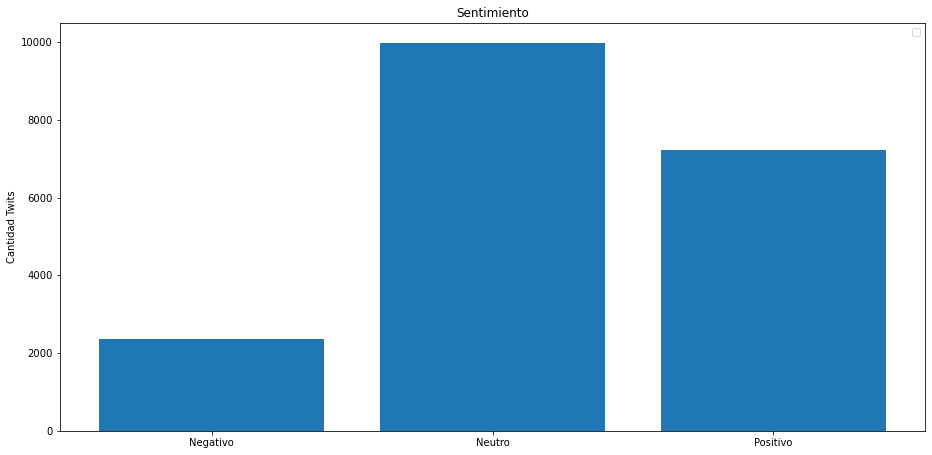

In [66]:
agrupacion_pais =data.groupby(['sentimiento'], as_index = False)[['tweet']].count()
#groupby("country")["name"].count()
agrupacion_pais
labels = agrupacion_pais["sentimiento"]
men_means =agrupacion_pais["tweet"]
width = 0.80       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)

ax.bar(labels, men_means, width)
#ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
#       label='Women')

ax.set_ylabel('Cantidad Twits')
ax.set_title('Sentimiento')
ax.legend()
plt.show()

# Nubes de palabras por sentimiento

In [79]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display

def generar_grafico(datos,imagen):
    calabaza = PIL.Image.open(imagen)
    mask = np.array(calabaza)
    palabras = datos.clean.str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400,
                         max_font_size=150, max_words=500,
                         background_color='black', 
                         colormap='copper_r',
                         stopwords=stopwords,
                         mask=mask, contour_width=0.5, contour_color='white').generate(palabras) # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
                         #title= "Ejemplo"
    wordcloud.to_file(imagen)

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title="Ejemplo"
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

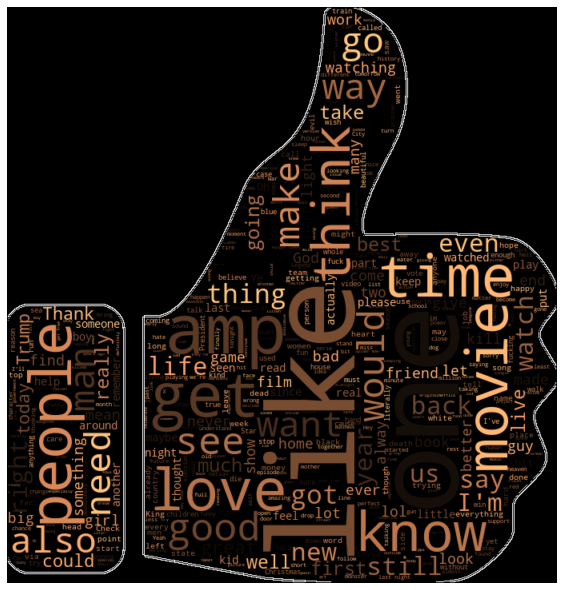

In [89]:
data_positivo=data[data['sentimiento']=="Positivo"]
generar_grafico(data,"positivo2.png")

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

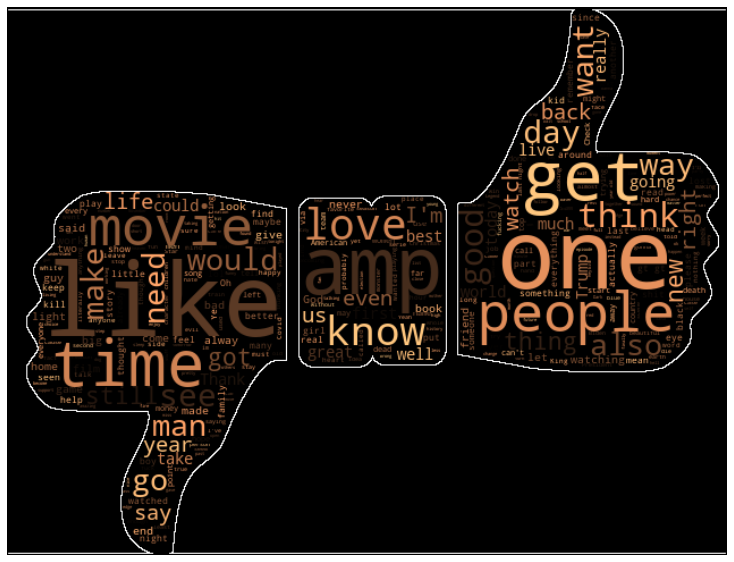

In [94]:
data_positivo=data[data['sentimiento']=="Neutro"]
generar_grafico(data,"neutro.png")

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

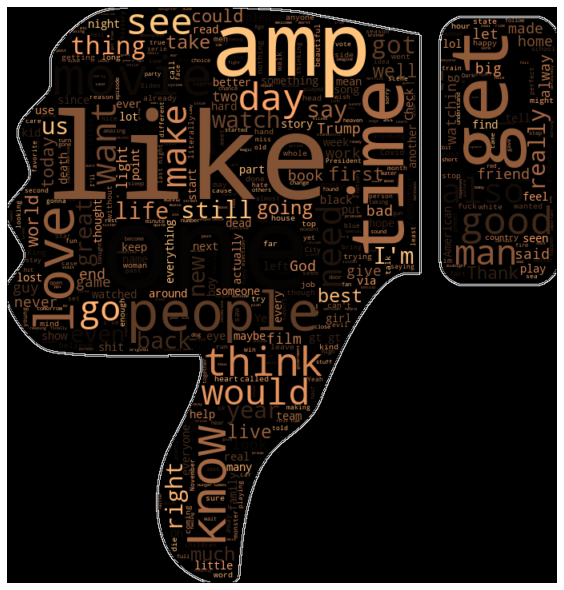

In [93]:
data_positivo=data[data['sentimiento']=="Negativo"]
generar_grafico(data,"negativo.png")

In [231]:
data_max=data.groupby(['Pelicula'], as_index = False)[['compound']].max()
data_max.rename(columns={"Pelicula": "name", "compound": "max_sentimiento"}, inplace=True)
data_min=data.groupby(['Pelicula'], as_index = False)[['compound']].min()
data_min.rename(columns={"Pelicula": "name", "compound": "min_sentimiento"}, inplace=True)
data_mean=data.groupby(['Pelicula'], as_index = False)[['compound']].mean()
data_mean.rename(columns={"Pelicula": "name", "compound": "mean_sentimiento"}, inplace=True)
data_max.head()

name  max_sentimiento
0                       '71           0.8679
1       10 Cloverfield Lane           0.9325
2          12 Years a Slave           0.9201
3  12 horas para sobrevivir           0.4588
4                   13 Sins           0.8519

In [233]:
temporal1=pd.merge(data_max,data_min,on='name')
temporal2=pd.merge(temporal1,data_mean,on='name')
temporal2.head()

name  max_sentimiento  min_sentimiento  \
0                       '71           0.8679          -0.9239   
1       10 Cloverfield Lane           0.9325          -0.9042   
2          12 Years a Slave           0.9201          -0.9767   
3  12 horas para sobrevivir           0.4588           0.4588   
4                   13 Sins           0.8519          -0.9344   

   mean_sentimiento  
0          0.104450  
1          0.070307  
2         -0.024473  
3          0.458800  
4         -0.056897

In [234]:
datos = pd.read_excel("base_final_movies.xlsx")

In [235]:
data1=pd.merge(datos,temporal2,on='name',how='left')
data1.head()

budget                        company country          director  \
0  100000000           Red Granite Pictures     USA   Martin Scorsese   
1   20000000                New Line Cinema     USA         James Wan   
2   46000000            Alcon Entertainment     USA  Denis Villeneuve   
3  150000000  Walt Disney Animation Studios     USA        Chris Buck   
4   75000000           Summit Entertainment     USA   Louis Leterrier   

       genre      gross                     name rating  day_released  \
0  Biography  116900694  The Wolf of Wall Street      R            25   
1     Horror  137400141            The Conjuring      R            19   
2      Crime   61002302                Prisoners      R            20   
3  Animation  400738009                   Frozen     PG            27   
4      Crime  117723989           Now You See Me  PG-13            31   

   month_released  ...  calificacion1 calificacion2  \
0              12  ...           80.0          83.0   
1               7  ...           86.0          83.0   
2               9  ...           81.0          87.0   
3              11  ...           56.0          57.0   
4               5  ...           51.0          70.0   

                                            synopsis  \
0  in 1987  jordan belfort  leonardo dicaprio  ta...   
1  in 1970  paranormal investigators and demonolo...   
2  keller dover  hugh jackman  faces a parent s w...   
3  a performance artist turns his suicide into a ...   
4  charismatic magician atlas  jesse eisenberg  l...   

                                                ruta promedio_ganancia  \
0  https://www.rottentomatoes.com/m/the_wolf_of_w...                 1   
1     https://www.rottentomatoes.com/m/the_conjuring                 0   
2    https://www.rottentomatoes.com/m/prisoners_2013                 1   
3            https://www.rottentomatoes.com/m/frozen                 0   
4    https://www.rottentomatoes.com/m/now_you_see_me                 1   

   calificacion1_dec calificacion2_dec  max_sentimiento min_sentimiento  \
0                4.0               4.0           0.8271         -0.8458   
1                4.0               4.0           0.8658         -0.8664   
2                4.0               4.0           0.9405         -0.8494   
3                3.0               3.0           0.9480         -0.7096   
4                3.0               4.0           0.9455         -0.7345   

  mean_sentimiento  
0         0.017757  
1         0.025267  
2        -0.074207  
3         0.168870  
4         0.359890  

[5 rows x 30 columns]

In [242]:
def desc_sentimiento2(row):
    numero = row['mean_sentimiento']
    if(numero>=0.4):
        descipcion="Positivo"
    elif(numero>=-0.6):
        descipcion="Neutro"
    else:
        descipcion="Negativo"
    return descipcion
data1['sentimiento'] = data1.apply(desc_sentimiento2, axis=1, result_type='expand')

No handles with labels found to put in legend.


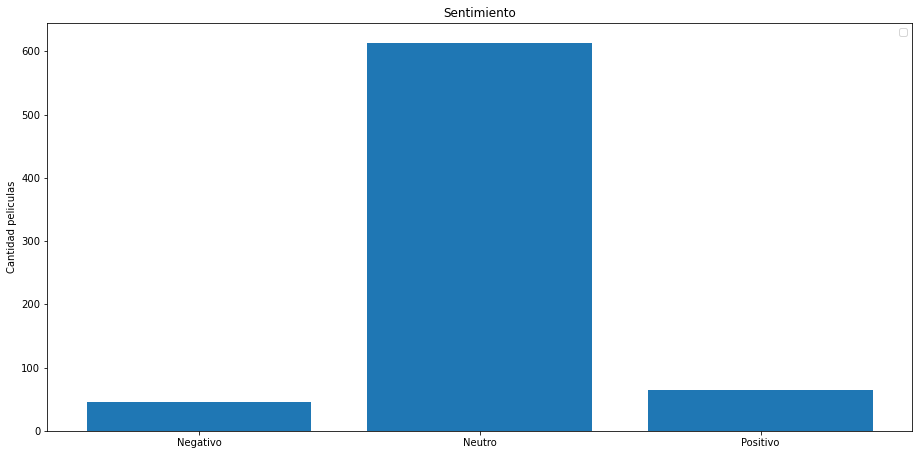

In [243]:
agrupacion_pais =data1.groupby(['sentimiento'], as_index = False)[['name']].count()
#groupby("country")["name"].count()
agrupacion_pais
labels = agrupacion_pais["sentimiento"]
men_means =agrupacion_pais["name"]
width = 0.80       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)

ax.bar(labels, men_means, width)
#ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
#       label='Women')

ax.set_ylabel('Cantidad peliculas')
ax.set_title('Sentimiento')
ax.legend()
plt.show()

In [248]:
data_positivo_final=data1[data1['sentimiento']=="Positivo"]
data_positivo_final[['budget','gross','name','calificacion1','calificacion2','mean_sentimiento','sentimiento']]

budget      gross                            name  calificacion1  \
32    60000000   19452138             Beautiful Creatures           38.0   
45    28000000   71349120                      Safe Haven           13.0   
58    35000000   66380662                     Warm Bodies           81.0   
66   215000000  234911825       Oz the Great and Powerful           57.0   
96           0      48022               Young & Beautiful           73.0   
..         ...        ...                             ...            ...   
686    8000000      35070          A Street Cat Named Bob           77.0   
693   13000000   61693523            Miracles from Heaven           45.0   
711    4000000   10732841                    The Darkness            3.0   
716          0     228894                  The Love Witch           95.0   
718          0    4750497  Absolutely Fabulous: The Movie           59.0   

     calificacion2  mean_sentimiento sentimiento  
32            32.0          0.647653    Positivo  
45            67.0          0.575770    Positivo  
58            73.0          0.414590    Positivo  
66            56.0          0.748903    Positivo  
96            61.0          0.649907    Positivo  
..             ...               ...         ...  
686           76.0          0.442323    Positivo  
693           81.0          0.582680    Positivo  
711           19.0          0.416170    Positivo  
716           61.0          0.485580    Positivo  
718           41.0          0.656550    Positivo  

[64 rows x 7 columns]

In [301]:
data1['prueba']= data1["name"].apply(lambda texto: pre_procesado2_s(str(texto)) )  

In [303]:
data1

budget                        company country          director  \
0    100000000           Red Granite Pictures     USA   Martin Scorsese   
1     20000000                New Line Cinema     USA         James Wan   
2     46000000            Alcon Entertainment     USA  Denis Villeneuve   
3    150000000  Walt Disney Animation Studios     USA        Chris Buck   
4     75000000           Summit Entertainment     USA   Louis Leterrier   
..         ...                            ...     ...               ...   
718          0       Fox Searchlight Pictures      UK   Mandie Fletcher   
719          0       Siempre Viva Productions     USA    Paul Duddridge   
720    3500000         Warner Bros. Animation     USA           Sam Liu   
721          0            Borderline Presents     USA     Nicolas Pesce   
722          0      Les Productions du Trésor  France     Nicole Garcia   

         genre      gross                            name rating  \
0    Biography  116900694         The Wolf of Wall Street      R   
1       Horror  137400141                   The Conjuring      R   
2        Crime   61002302                       Prisoners      R   
3    Animation  400738009                          Frozen     PG   
4        Crime  117723989                  Now You See Me  PG-13   
..         ...        ...                             ...    ...   
718     Comedy    4750497  Absolutely Fabulous: The Movie      R   
719      Drama      28368           Mothers and Daughters  PG-13   
720  Animation    3775000        Batman: The Killing Joke      R   
721      Drama      25981           The Eyes of My Mother      R   
722      Drama      37757       From the Land of the Moon      R   

     day_released  month_released  ...  \
0              25              12  ...   
1              19               7  ...   
2              20               9  ...   
3              27              11  ...   
4              31               5  ...   
..            ...             ...  ...   
718            22               7  ...   
719             6               5  ...   
720            25               7  ...   
721             2              12  ...   
722            28               7  ...   

                                              synopsis  \
0    in 1987  jordan belfort  leonardo dicaprio  ta...   
1    in 1970  paranormal investigators and demonolo...   
2    keller dover  hugh jackman  faces a parent s w...   
3    a performance artist turns his suicide into a ...   
4    charismatic magician atlas  jesse eisenberg  l...   
..                                                 ...   
718  publicist edina monsoon and best friend patsy ...   
719  a pregnant photographer  selma blair  captures...   
720  batman  kevin conroy  must save commissioner g...   
721  francisca  kika magalhaes  has been unfazed by...   
722  after world war ii  a free spirited woman  mar...   

                                                  ruta  promedio_ganancia  \
0    https://www.rottentomatoes.com/m/the_wolf_of_w...                  1   
1       https://www.rottentomatoes.com/m/the_conjuring                  0   
2      https://www.rottentomatoes.com/m/prisoners_2013                  1   
3              https://www.rottentomatoes.com/m/frozen                  0   
4      https://www.rottentomatoes.com/m/now_you_see_me                  1   
..                                                 ...                ...   
718  https://www.rottentomatoes.com/m/absolutely_fa...                  0   
719  https://www.rottentomatoes.com/m/mothers_and_d...                  0   
720  https://www.rottentomatoes.com/m/batman_the_ki...                  1   
721  https://www.rottentomatoes.com/m/the_eyes_of_m...                  0   
722  https://www.rottentomatoes.com/m/from_the_land...                  0   

     calificacion1_dec calificacion2_dec  max_sentimiento min_sentimiento  \
0                  4.0               4.0           0.8271         -0.8458   
1        